# Cytoid-AI-charting

## Data Preposessing

In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))

Using GPU: NVIDIA GeForce RTX 4090


In [2]:
from pathlib import Path
import json

def contains_non_ascii(s):
    return any(ord(c) > 127 for c in s)

def extract_level_json(directory):
    result = {}
    directory = Path(directory)

    for folder_path in directory.iterdir():
        json_file_path = folder_path / 'level.json'
        if json_file_path.is_file():
            with json_file_path.open('r', encoding='utf-8') as json_file:
                level_data = json.load(json_file)

            audio_file_name = level_data['music']['path']
            audio_file_extensions = ['.mp3', '.ogg', '.wav']
            audio_file_path = None

            for ext in audio_file_extensions:
                aud_path = folder_path / audio_file_name
                if aud_path.suffix.lower() == ext and aud_path.is_file():
                    audio_file_path = aud_path
                else:
                    # print(f"Audio file not found: {aud_path}")
                    continue
            if audio_file_path is None:
                continue  
        
            # Check if the file name contains non-ASCII characters, like chinese, japanese, and special characters
            charts_path = folder_path / level_data['charts'][0]['path']
            file_info = [
                ('audio', audio_file_path, level_data['music'], 'path', audio_file_path.suffix),
                ('chart', charts_path, level_data['charts'][0], 'path', '.json')
            ]
            for file_type, file_path, data_entry, path_key, file_extension in file_info:
                filename = file_path.name 
                if contains_non_ascii(filename):
                    if 'id' in level_data and level_data['id']:
                        new_filename = f"{level_data['id']}{file_extension}"
                        new_file_path = file_path.with_name(new_filename)
                        try: # Attempt to rename the file
                            file_path.rename(new_file_path)
                            data_entry[path_key] = new_filename
                            if file_type == 'audio':
                                audio_file_path = new_file_path
                            else:
                                charts_path = new_file_path
                        except :
                                # print(f"Failed to rename {file_type} file: {file_path}")
                            continue
                    else:
                        # print(f"Non-ASCII characters found in {file_type} file name: {file_path}")
                        continue
            result[level_data['id']] = {
                'level': level_data,
                'mp3_path': str(audio_file_path),
                'charts_path': str(charts_path),
                'charter': level_data['charter'],
                'type': level_data['charts'][0]['type'],
                'difficulty': level_data['charts'][0]['difficulty']
            }
    return result
current_directory = Path().cwd()
data = extract_level_json(current_directory / "dataset/Z")
# print(data)

In [3]:
from pathlib import Path
import json
from collections import Counter

def extract_charts(path):
    file_path = Path(path)
    if file_path.exists() and file_path.is_file():
        with open(file_path, 'r', encoding='utf-8') as f:
            try:
                data = json.load(f)
                return data
            except:
                pass
    return None  # Return None if the file doesn't exist or is invalid

def find_single_tempo_songs(data):
    single_tempo_songs = []
    for song_id in data:
        song = data[song_id]
        charts_data = extract_charts(song['charts_path'])
        if charts_data and 'tempo_list' in charts_data:
            if len(charts_data['tempo_list']) == 1:
                single_tempo_songs.append(song)
    return single_tempo_songs

# Assuming 'data' is your dataset containing song information
single_tempo_songs = find_single_tempo_songs(data)

print('Total Songs: ', len(data))
print('Songs with single tempo: ', len(single_tempo_songs))

# Counting the difficulties
difficulty_counter = Counter()
for song in single_tempo_songs:
    difficulty_counter[song['difficulty']] += 1

sorted_difficulties = sorted(difficulty_counter.items(), key=lambda x: x[0], reverse=True)
for difficulty, count in sorted_difficulties:
    print(f"difficulty: {difficulty}, numbers: {count}")


Total Songs:  136
Songs with single tempo:  66
difficulty: 16, numbers: 21
difficulty: 15, numbers: 18
difficulty: 14, numbers: 8
difficulty: 13, numbers: 8
difficulty: 12, numbers: 3
difficulty: 11, numbers: 2
difficulty: 10, numbers: 1
difficulty: 9, numbers: 2
difficulty: 3, numbers: 1
difficulty: 0, numbers: 2


In [4]:
# Mel vis
import librosa
import matplotlib.pyplot as plt
def vis_mel(start_time, end_time, log_mel_spec, sr):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_mel_spec, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.xlim(start_time, end_time)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.show()

In [5]:
def map_note_to_time(data):
    time_base = data['time_base'] 
    offset_universal = 0.033 
    try: 
        offset = data['music_offset'] - offset_universal
    except:
        offset = 0 - offset_universal
    # offset = 0
    tempo_list = sorted(data['tempo_list'], key=lambda x: x['tick'])  
    note_list = data['note_list']
    
    note_time_map = []
    accumulated_time = 0 
    last_tick = 0  
    current_tempo = tempo_list[0]['value']  
    tempo_index = 0  

    for note in note_list:
        note_tick = note['tick']
        while tempo_index < len(tempo_list) - 1 and tempo_list[tempo_index + 1]['tick'] <= note_tick:
            next_tempo_tick = tempo_list[tempo_index + 1]['tick']
            
            ticks_in_interval = next_tempo_tick - last_tick
            tick_duration = (current_tempo / time_base) 
            accumulated_time += ticks_in_interval * tick_duration
            
            last_tick = next_tempo_tick
            tempo_index += 1
            current_tempo = tempo_list[tempo_index]['value']

        ticks_in_interval = note_tick - last_tick
        tick_duration = (current_tempo / time_base) 
        note_time = accumulated_time + ticks_in_interval * tick_duration
        note_time_map.append({
            'note_id': note['id'],
            'note_tick': note_tick,
            'note_time_microseconds': note_time - offset * 1_000_000, # 加会有负数，那么只能是减了
        })

    return note_time_map

In [6]:
import numpy as np
import matplotlib.pyplot as plt

for level in single_tempo_songs[:10]:
    mp3_path = level["mp3_path"]
    charts_path = level["charts_path"]
    try:
        y, sr = librosa.load(mp3_path, sr=None)
    except FileNotFoundError:
        print(f"File not found: {mp3_path}")
    charts_data = extract_charts(charts_path)
    note_time_map = map_note_to_time(charts_data)
    print(note_time_map)
    # [{'note_id': 0, 'note_tick': 1920, 'note_time_microseconds': 1714284.0}, {'note_id': 1, 'note_tick': 2040, 'note_time_microseconds': 1821426.75}]
    
    # # 检查是否note->t map正确
    # mp3_t = len(y) / sr  
    # note_time_map = map_note_to_time(charts_data)
    # last_note_time_microseconds = note_time_map[-1]['note_time_microseconds']
    # dur = last_note_time_microseconds / 1_000_000  
    # print(f"Original : {mp3_t:.2f} s, cal: {dur:.2f} s, Diff: {(mp3_t - dur):.2f} s, {level['level']['id']}")

[{'note_id': 0, 'note_tick': 3840, 'note_time_microseconds': 2942088.0}, {'note_id': 1, 'note_tick': 4320, 'note_time_microseconds': 3305724.0}, {'note_id': 2, 'note_tick': 4440, 'note_time_microseconds': 3396633.0}, {'note_id': 3, 'note_tick': 4500, 'note_time_microseconds': 3442087.5}, {'note_id': 4, 'note_tick': 4560, 'note_time_microseconds': 3487542.0}, {'note_id': 5, 'note_tick': 4620, 'note_time_microseconds': 3532996.5}, {'note_id': 6, 'note_tick': 4680, 'note_time_microseconds': 3578451.0}, {'note_id': 7, 'note_tick': 4800, 'note_time_microseconds': 3669360.0}, {'note_id': 8, 'note_tick': 4800, 'note_time_microseconds': 3669360.0}, {'note_id': 9, 'note_tick': 5040, 'note_time_microseconds': 3851178.0}, {'note_id': 10, 'note_tick': 5160, 'note_time_microseconds': 3942087.0000000005}, {'note_id': 11, 'note_tick': 5520, 'note_time_microseconds': 4214814.0}, {'note_id': 12, 'note_tick': 5520, 'note_time_microseconds': 4214814.0}, {'note_id': 13, 'note_tick': 7680, 'note_time_micro

In [7]:
test_data = data['z.pluto']
mp3_path = test_data["mp3_path"]
for key in charts_data.keys():
    try:
        print(key, charts_data[key][:10])
    except:
        print(key, charts_data[key])
# Mel
y, sr = librosa.load(mp3_path, sr=None)
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
log_mel_spec = librosa.power_to_db(mel_spec)
charts_path = test_data["charts_path"]
charts_data = extract_charts(charts_path)
note_time_map = map_note_to_time(charts_data)

page_list [{'start_tick': 0, 'end_tick': 960, 'scan_line_direction': 1}, {'start_tick': 960, 'end_tick': 1920, 'scan_line_direction': -1}, {'start_tick': 1920, 'end_tick': 2880, 'scan_line_direction': 1}, {'start_tick': 2880, 'end_tick': 3840, 'scan_line_direction': -1}, {'start_tick': 3840, 'end_tick': 4800, 'scan_line_direction': 1}, {'start_tick': 4800, 'end_tick': 5760, 'scan_line_direction': -1}, {'start_tick': 5760, 'end_tick': 6720, 'scan_line_direction': 1}, {'start_tick': 6720, 'end_tick': 7680, 'scan_line_direction': -1}, {'start_tick': 7680, 'end_tick': 8640, 'scan_line_direction': 1}, {'start_tick': 8640, 'end_tick': 9600, 'scan_line_direction': -1}]
note_list [{'id': 0, 'page_index': 1, 'tick': 1920, 'x': 0.5, 'type': 5, 'next_id': 0, 'hold_tick': 0, 'has_sibling': False, 'is_forward': False}, {'id': 1, 'page_index': 3, 'tick': 3840, 'x': 0.5, 'type': 0, 'next_id': 0, 'hold_tick': 0, 'has_sibling': False, 'is_forward': False}, {'id': 2, 'page_index': 5, 'tick': 5760, 'x': 

### 检查是否note->t map正确

In [8]:
# import numpy as np
# import librosa
# import librosa.display
# import matplotlib.pyplot as plt
# from matplotlib.ticker import FormatStrFormatter

# def visualize_level(level, start_time, end_time):
#     mp3_path = level["mp3_path"]
#     y, sr = librosa.load(mp3_path, sr=None)
#     hop_length = 256
#     mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000, hop_length=hop_length)
#     log_mel_spec = librosa.power_to_db(mel_spec)
    
#     charts_path = level["charts_path"]
#     charts_data = extract_charts(charts_path)
#     note_time_map = map_note_to_time(charts_data)
#     note_times_sec = [note['note_time_microseconds'] / 1e6 for note in note_time_map]
#     plt.figure(figsize=(12, 6))

#     librosa.display.specshow(log_mel_spec, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', fmax=8000)
#     plt.colorbar(format='%+2.0f dB')
#     plt.title('Mel')
#     plt.xlim(start_time, end_time)

#     for note in note_time_map:
#         nt = note['note_time_microseconds'] / 1e6
#         if start_time <= nt <= end_time:
#             plt.axvline(x=nt, color='black', linestyle='--', linewidth=1)
#             plt.text(nt, plt.ylim()[1], f"{nt:.3f}", rotation=90, va='bottom', ha='center', color='blue')
#     plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
#     plt.xlabel('Time(s)')
#     plt.ylabel('Freq')
#     plt.show()

# for level in single_tempo_songs[:20]:
#     visualize_level(level, 50, 51)


In [9]:
# 这个证明多节拍的找错了
# for i in [50, 100, 150, 200, 250]:    
#     visualize_level(data['z.alepri'], i, i+1)

In [10]:
def find_event_page(data):
    page_events = []  
    for event in data['event_order_list']:
        event_tick = event['tick']
        for page in data['page_list']:
            if page['start_tick'] <= event_tick < page['end_tick']:
                page_events.append({
                    'event_tick': event_tick,
                    'event': event['event_list'],
                    'page': page
                })
                break
    return page_events
page_events = find_event_page(charts_data)
for pe in page_events:
    pass
    print(f"Event at tick {pe['event_tick']}  st: {pe['page']['start_tick']}, end: {pe['page']['end_tick']} dis={-(pe['page']['start_tick']-pe['page']['end_tick'])}")

Event at tick 9840  st: 9120, end: 10080 dis=960
Event at tick 31920  st: 31680, end: 32160 dis=480
Event at tick 39600  st: 38880, end: 39840 dis=960


In [11]:
    
def find_tempo_page(data):
    tempo_pages = []  
    for tempo in data['tempo_list']:
        tempo_tick = tempo['tick']
        for page in data['page_list']:
            if page['start_tick'] <= tempo_tick < page['end_tick']:
                tempo_pages.append({
                    'tempo_tick': tempo_tick,
                    'tempo_value': tempo['value'],
                    'page': page
                })
                break
                
    return tempo_pages
tempo_pages = find_tempo_page(charts_data)
for tp in tempo_pages:
    pass
    print(f"Tempo at tick {tp['tempo_tick']} with value {tp['tempo_value']} is in page starting at tick {tp['page']['start_tick']} and ending at tick {tp['page']['end_tick']}. Duration: {tp['page']['end_tick'] - tp['page']['start_tick']} ticks.")


Tempo at tick 0 with value 833333 is in page starting at tick 0 and ending at tick 480. Duration: 480 ticks.


table for chart keys click to reveal 
<!-- 
| Key                          | Subkey                                   | Data Type       |  
|------------------------------|------------------------------------------|-----------------|
| `page_list`                   | 页面 (扫描线)            | List            |  
|                              | `start_tick` (Page start)  | Integer         |  
|                              | `end_tick`  (Page end)      | Integer         |  
|                              | `scan_line_direction` 扫描线方向         | Integer (1 or -1) |  
| `tempo_list`                  |                        | List            |  
|                              | `tick` time t               | Integer         |  
|                              | `value` Tempo value             | Integer         |  
| `music_offset`                |  (Music offset)                  | Integer         |  
| `event_order_list`            |         | List            |
|          |`type` 0: speed up, 1: slow down        | [0,1] matters, when it equals to other number then ignore            |
|          |`args` when type=0/1, "W"等于，"R"大于, "G"小于 timebase        |['R', 'W', 'G']           |
| `note_list`                   | all the notes                     | List            |  
|                    | `type` note type                    | Integer in 0-7, each indicate a type          |  
|                    |`id` note id                   |Integer        |  
|                    | `tick` at time t                  | Integer           |
|                    | `x` at place x                  | Float in [0,1]            |  
|                    | `hold_tick` how many ticks a hlod last when type=1,2        | Integer            |  
 -->


## network

### Input Preprocessing

#### Necessary funcs

In [12]:
# STFT constant
SAMPLE_RATE = 22050  
HOP_LENGTH = 512     
NMELS = 156        
FRAME = 32     


In [13]:
import enum
class TimeUnit(enum.Enum):
    milliseconds = "milliseconds"
    frames = "frames"
    seconds = "seconds"


from torch.nn.utils.rnn import pad_sequence
def collate_fn_padded(batch):
    mel, labels = zip(*batch)
    lengths = [m.shape[0] for m in mel]
    
    # Pad Mel spectrograms
    mel_padded = pad_sequence(mel, 
                              batch_first=True, 
                              padding_value=0)  # shape: (batch_size, max_seq_len, n_mels)
    
    # Pad labels
    labels_padded = pad_sequence(labels, 
                                 batch_first=True, 
                                 padding_value=0)  # shape: (batch_size, max_seq_len, 1)
    
    return mel_padded, labels_padded, lengths


In [14]:
from typing import List, Tuple, Dict
import torch.nn.functional as F

def process_bpminfo(
    bpm_info: List[Dict[str, float]],  
    max_length_ms: int,
    units: TimeUnit = TimeUnit.milliseconds
) -> Tuple[List[float], List[float], List[float], List[int]]:
    bpms, starts, ends, beats = [], [], [], []
    max_length = convert_units(max_length_ms, units)

    for i, tempo_event in enumerate(bpm_info):
        tick = tempo_event['tick']
        value = tempo_event['value']
        start = convert_units(tick * FRAME, TimeUnit.milliseconds) 
        if start > max_length:
            continue
        bpm = 60000000 / value  
        bpms.append(bpm)
        starts.append(start)
        beats.append(4)  
        if i < len(bpm_info) - 1:
            next_tick = bpm_info[i + 1]['tick']
            next_start = convert_units(next_tick * FRAME, TimeUnit.milliseconds)
            ends.append(min(next_start, max_length))
        else:
            ends.append(max_length)
    
    return bpms, starts, ends, beats # 将tick转换为ms， 这个处理的是

def convert_units(value: float, units: TimeUnit) -> float:
    if units == TimeUnit.milliseconds:
        return float(value)
    elif units == TimeUnit.seconds:
        return float(value) / 1000.0
    elif units == TimeUnit.frames:
        return float(value) * FRAME  
    else:
        raise ValueError("convert_units error")

def gen_beats_array(
    length: int,
    bpm_info: List[Dict[str, float]],  # tempo_list [{'tick': 0, 'value': 300000}]
    mel_length: int,
    is_downbeat: bool = True,
):

    arr = np.zeros(length)
    bpms, starts, ends, beats = process_bpminfo(      # Porcess bpm_info used here:  Tuple[List[float], List[float], List[float], List[int]]
        bpm_info, mel_length * FRAME, units=TimeUnit.milliseconds
    )
    for bpm, start, end, beat in zip(bpms, starts, ends, beats):
        interval = 60000 / bpm  # 毫秒
        beats_timing = np.arange(start, end, interval)
        arg_beats = np.round(beats_timing / FRAME).astype("int64")
        arg_beats = arg_beats[arg_beats < length]  

        for b in range(beat):
            if b == 0:  #
                if is_downbeat:
                    arr[arg_beats[b::beat]] = 2
                else:
                    arr[arg_beats[b::beat]] = 1
            else:  
                arr[arg_beats[b::beat]] = 1

    return arr.reshape([-1, 1])

#### generate mel spectrogram

In [15]:
def add_white_noise(x: np.ndarray, rate: float = 0.005) -> np.ndarray:
    return x + rate * np.random.randn(len(x))

def shift(ar, size, med):
    if size > 0:
        ar = F.pad(ar[size:], [0, size]) + F.pad(ar[:-size], [size, 0])
    ar = ar * (med - size)
    return ar

def gauss(ar, width=3, scale=1.0):
    t = torch.stack([shift(ar, i, width) for i in range(width)])
    t = torch.max(t, dim=0)[0]
    mask = t == 0
    std = width / 3
    var = std**2
    t2 = torch.exp(-((t - width) ** 2) / (2 * var)) * scale
    return torch.max(t2.masked_fill(mask, 0), ar.float())

def round_decimal(tensor: torch.Tensor, decimals: int) -> torch.Tensor:
    multiplier = 10 ** decimals
    return torch.round(tensor * multiplier) / multiplier

def fuzzy_label(onset_label: torch.Tensor, width: int, scale: float) -> torch.Tensor:
    assert width > 0
    assert 0 <= scale <= 1
    return round_decimal(gauss(onset_label.view(-1), width, scale), 2).view(len(onset_label), 1)

def fuzzy_on_batch(batch: torch.Tensor, width: int, scale: float) -> torch.Tensor:
    fuzzy_labeled = []
    for x in range(batch.shape[0]):
        fuzzy_labeled.append(fuzzy_label(batch[x], width, scale))
    return torch.stack(fuzzy_labeled)

In [16]:
# process the input of the LSTM model, in: , out:fuzzy lable
def generate_mel_spectrogram(
    audio_path: Path,
    aug_count: int = 0,
    log_enable: bool = True,
    noise_rate: float = 0.005,
    bpm_info: List[Tuple[float, float, int]] = None,
    score_positions: List[int] = None
) -> dict:
    
    data, sr = librosa.load(str(audio_path), sr=SAMPLE_RATE)
    assert sr == SAMPLE_RATE, f"Expected sample rate {SAMPLE_RATE}, but got {sr}"

    mel = librosa.feature.melspectrogram(
        y=data,
        sr=sr, 
        hop_length=HOP_LENGTH, 
        fmin=30.0, 
        n_mels=NMELS, 
        htk=True
    )
    if log_enable:
        mel = np.log(np.clip(mel, 1e-5, None))
    mel = mel.T  # (time steps, features)
    data_dic = {"mel": mel}

    if bpm_info and score_positions:
        mel_length = mel.shape[0]
        beats_array = gen_beats_array(
            length=mel_length,
            bpm_info=bpm_info,
            mel_length=mel_length,
            is_downbeat=True
        )
        onset_labels = np.zeros(mel_length)
        for pos in score_positions:
            if pos < mel_length:
                onset_labels[pos] = 1  # 标记为onset

        onset_labels_tensor = torch.tensor(onset_labels).float().unsqueeze(0).unsqueeze(-1)  # shape: (1, mel_length, 1)
        fuzzy_onset_labels = fuzzy_on_batch(onset_labels_tensor, width=2, scale=1.0)
        data_dic["fuzzy_onset"] = fuzzy_onset_labels.squeeze(0).numpy()  # shape: (mel_length, 1)

    # Data Augmentation
    for idx in range(aug_count):
        noisy_data = add_white_noise(data, rate=noise_rate)
        mel_noisy = librosa.feature.melspectrogram(
            y=noisy_data,
            sr=sr, 
            hop_length=HOP_LENGTH, 
            fmin=30.0, 
            n_mels=NMELS, 
            htk=True
        )
        if log_enable:
            mel_noisy = np.log(np.clip(mel_noisy, 1e-5, None))
        mel_noisy = mel_noisy.T
        data_dic[f"mel_noise_{idx}"] = mel_noisy

    return data_dic

#### Input datatype

In [17]:
from torch.utils.data import Dataset
class OnsetDataset(Dataset):
    def __init__(self, data, bpm_info, score_positions, transform=None):
        self.data = data
        self.bpm_info = bpm_info
        self.score_positions = score_positions
        self.transform = transform
        self.samples = self.prepare_samples()
    
    def prepare_samples(self):
        samples = []
        for song_id in self.data:
            song = self.data[song_id]
            mp3_path = song["mp3_path"]
            charts_path = song["charts_path"]
            
            mel_dict = generate_mel_spectrogram(
                audio_path=Path(mp3_path),
                aug_count=0,  
                log_enable=True,
                noise_rate=0.005,
                bpm_info=self.bpm_info.get(song_id, None),
                score_positions=self.score_positions.get(song_id, None)
                
            )
            
            if "fuzzy_onset" in mel_dict:
                mel = mel_dict["mel"]
                labels = mel_dict["fuzzy_onset"]
                samples.append((mel, labels))
        
        return samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        mel, labels = self.samples[idx]
        mel = torch.from_numpy(mel).float()  # shape: (time_steps, n_mels)
        labels = torch.from_numpy(labels).float()  # shape: (time_steps, 1)
        
        if self.transform:
            mel, labels = self.transform(mel, labels)
        
        return mel, labels

### LSTM model

In [18]:
from torch import nn
class OnsetLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.5):
        super(OnsetLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, 
                            batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, 1)  
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # (batch_size, seq_len, hidden_size * 2)
        out = self.fc(lstm_out)  # (batch_size, seq_len, 1)
        out = self.sigmoid(out)  # (batch_size, seq_len, 1)
        return out

### train

In [19]:
import tqdm
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False,
                       bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]',
                       dynamic_ncols=True)
    
    for mel, labels, lengths in progress_bar:
        mel = mel.to(device)  # shape: (batch_size, max_seq_len, n_mels)
        labels = labels.to(device)  # shape: (batch_size, max_seq_len, 1)
        outputs = model(mel)  # shape: (batch_size, max_seq_len, 1)
        mask = torch.zeros_like(labels).to(device)
        for i, length in enumerate(lengths):
            mask[i, :length, 0] = 1  # 1: used for training, 0: not used
        loss = criterion(outputs * mask, labels * mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})
    
    epoch_loss = running_loss / len(dataloader)
    return epoch_loss

### evaluate


In [20]:
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    progress_bar = tqdm(dataloader, desc="Validation", leave=False, bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', dynamic_ncols=True)
    
    with torch.no_grad():
        for mel, labels, lengths in progress_bar:
            mel = mel.to(device)
            labels = labels.to(device)
            outputs = model(mel)
            mask = torch.zeros_like(labels).to(device)
            for i, length in enumerate(lengths):
                mask[i, :length, 0] = 1
            loss = criterion(outputs * mask, labels * mask)
            running_loss += loss.item()
            progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})
    
    epoch_loss = running_loss / len(dataloader)
    return epoch_loss

def predict_onset(model, mel, device):
    model.eval()
    with torch.no_grad():
        mel_tensor = torch.from_numpy(mel).float().unsqueeze(0).to(device)  # shape: (1, seq_len, n_mels)
        preds = model(mel_tensor)  # shape: (1, seq_len, 1)
        preds = preds.squeeze(0).cpu().numpy()  # shape: (seq_len, 1)
    return preds

## Visualize Result

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
current_directory = Path().cwd()
data = extract_level_json(current_directory / "dataset/Z")
single_tempo_songs = find_single_tempo_songs(data)

bpm_info_dict = {}
score_positions_dict = {}

for song in single_tempo_songs:
    song_id = song['level']['id']
    charts_data = extract_charts(song['charts_path'])
    if charts_data:
        bpm_info = charts_data['tempo_list']
        bpm_info_dict[song_id] = bpm_info
        note_time_map = map_note_to_time(charts_data) 
        # List with        
        # [{
        #     'note_id': note['id'],
        #     'note_tick': note_tick,
        #     'note_time_microseconds': note_time - offset * 1_000_000, # 加会有负数，那么只能是减了
        # }]
        score_positions = [] 
        for note in note_time_map:
            time_sec = note['note_time_microseconds'] / 1_000_000
            # Convert seconds to frame index
            frame_idx = int(time_sec * SAMPLE_RATE / HOP_LENGTH)
            score_positions.append(frame_idx)
        score_positions_dict[song_id] = score_positions

# Create dataset
dataset = OnsetDataset(data=data, bpm_info=bpm_info_dict, score_positions=score_positions_dict)

Using device: cuda


In [22]:
# Hyper params for model
input_size = NMELS 
hidden_size = 128
num_layers = 2
dropout = 0.5
num_epochs = 50

In [23]:
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn_padded)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate_fn_padded)

model = OnsetLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
model.to(device)


criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
best_val_loss = float('inf')
epoch_progress = tqdm(range(num_epochs), desc="Epochs", bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', dynamic_ncols=False)

for epoch in epoch_progress:
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate_epoch(model, val_loader, criterion, device)
    # epoch_progress.set_postfix({'loss': f"{val_loss:.4f}"})
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_onset_lstm_model.pth")
        # epoch_progress.write(f'Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}/n')

model.load_state_dict(torch.load("best_onset_lstm_model.pth"))
model.to(device)
model.eval()

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


#### Vis

In [ ]:
def visualize_prediction(mel, labels, preds, start_time=0, end_time=None):
    SAMPLE_RATE = 22050  
    HOP_LENGTH = 512    
    total_frames = mel.shape[0]
    total_time = total_frames * HOP_LENGTH / SAMPLE_RATE 
    if end_time is None or end_time > total_time:
        end_time = total_time
    start_time = max(0, start_time)
    end_time = min(end_time, total_time)
    if start_time >= end_time:
        raise ValueError("st >= end")
    start_frame = int(start_time * SAMPLE_RATE / HOP_LENGTH)
    end_frame = int(end_time * SAMPLE_RATE / HOP_LENGTH)
    mel_cropped = mel[start_frame:end_frame]
    labels_cropped = labels[start_frame:end_frame]
    preds_cropped = preds[start_frame:end_frame]
    times = np.linspace(start_time, end_time, num=mel_cropped.shape[0])
    fig, ax1 = plt.subplots(figsize=(15, 8))
    img = librosa.display.specshow(
        mel_cropped.T, 
        sr=SAMPLE_RATE, 
        hop_length=HOP_LENGTH, 
        x_coords=times, 
        x_axis='time', 
        y_axis='mel', 
        fmax=8000,
        ax=ax1
    )
    fig.colorbar(img, ax=ax1, format='%+2.0f dB')
    ax1.set_title('Mel Spectrogram with Onset Labels and Predictions')
    ax2 = ax1.twinx()
    ax2.set_ylim(0, 2.5)  
    ax2.plot(times, labels_cropped, label='True Labels', color='green', alpha=0.6)
    ax2.plot(times, preds_cropped, label='Predicted Probability', color='red', alpha=0.6)
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_2, labels_2, loc='upper right')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Mel Frequency')
    ax2.set_ylabel('Onset Labels / Probability')
    plt.tight_layout()
    plt.show()

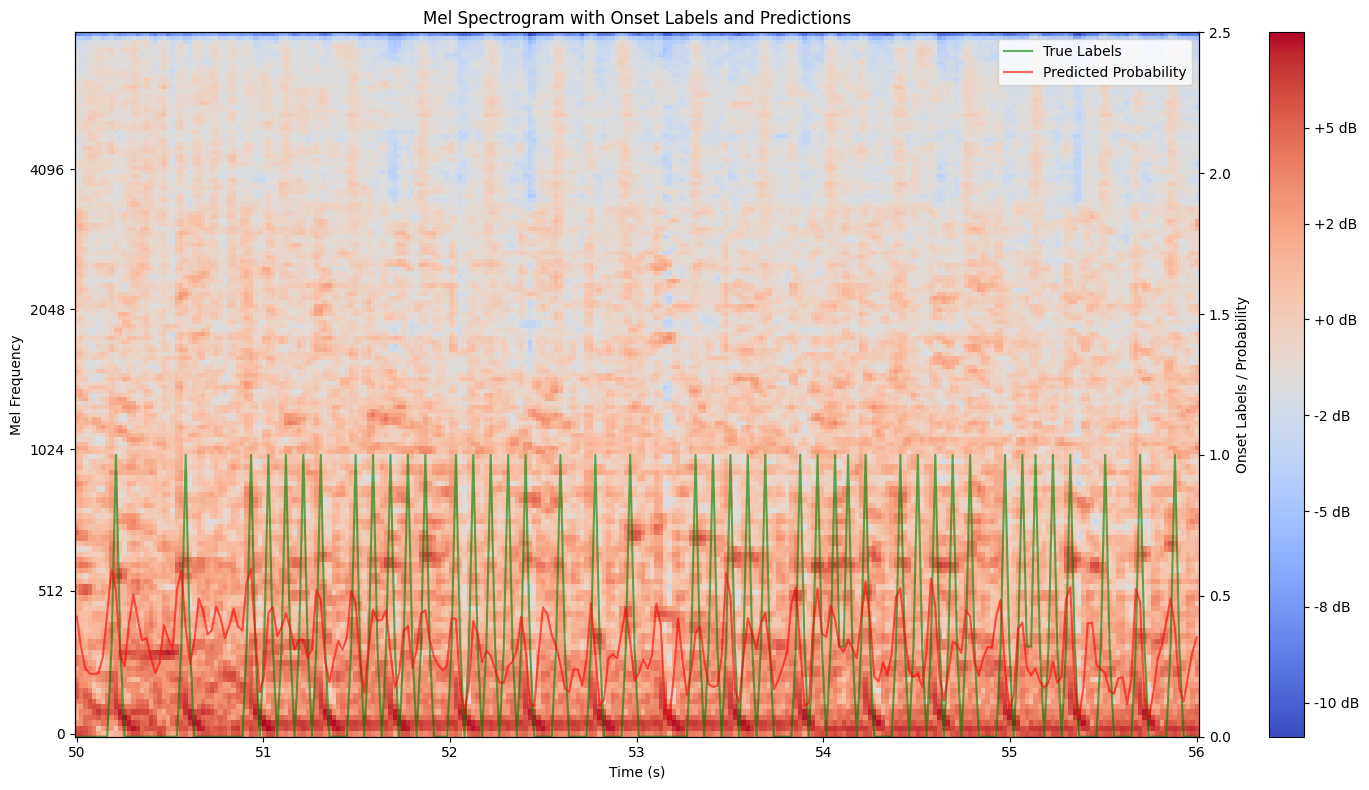

In [ ]:
sample_mel, sample_labels = dataset[0]  # Get the first sample
sample_mel_np = sample_mel.numpy()  # Convert to numpy array
sample_labels_np = sample_labels.numpy()  # Convert to numpy array
preds = predict_onset(model, sample_mel_np, device)
start_time = 50
end_time = 56
visualize_prediction(sample_mel_np, sample_labels_np, preds, start_time, end_time)